# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
*Taken from*: https://keras.io/examples/generative/vae/

## Setup and AUX functions

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
tf.__version__

'2.8.0'

In [3]:
# Create a custom layer for sampling
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
# Create base VAE model as a class, with a custom train_step
class VAE(keras.Model):
  def __init__(self, encoder, decoder, gamma, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    self.gamma = gamma

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.reconstruction_loss_tracker,
      self.kl_loss_tracker,
    ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
        tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction))
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + self.gamma * kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)

    return {
      "loss": self.total_loss_tracker.result(),
      "reconstruction_loss": self.reconstruction_loss_tracker.result(),
      "kl_loss": self.kl_loss_tracker.result(),
    }

In [5]:
# Plot loss
def plot_losses(vae):
  plt.figure(figsize=(18, 4))
  plt.subplot(1, 2, 1)
  plt.title('Reconstruction loss')
  plt.plot(vae.history.history['reconstruction_loss'], label='Training', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.subplot(1, 2, 2)
  plt.title('Gaussian loss')
  plt.plot(vae.history.history['kl_loss'], label='Training', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.grid(True)
  plt.show()

In [6]:
# Boxplot of variables in the latent space
def plot_z_distribution(vae, data):
  z_mean, _, _ = vae.encoder.predict(data)
  plt.figure(figsize=(10, 4))
  plt.boxplot(z_mean)
  plt.xlabel('Latent space variables')
  plt.ylabel('Values distribution')
  plt.xticks(ticks=[1, 2], labels=['z1', 'z2'])
  plt.grid()
  plt.show()

In [7]:
# 2D plot of the points mapped to the latent space
def plot_label_clusters(vae, data, labels):
  z_mean, _, _ = vae.encoder.predict(data)
  plt.figure(figsize=(8, 6))
  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='Spectral')
  plt.colorbar()
  plt.xlabel("z1")
  plt.ylabel("z2")
  plt.show()

In [8]:
# Plot manifold for sampling
def plot_latent_space(vae, n=30, figsize=10):
  # display a n*n 2D manifold
  digit_size = 28
  scale = 1.0
  figure = np.zeros((digit_size * n, digit_size * n))
  # linearly spaced coordinates corresponding to the 2D plot
  # of digit classes in the latent space
  grid_x = np.linspace(-scale, scale, n)
  grid_y = np.linspace(-scale, scale, n)[::-1]

  for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
      z_sample = np.array([[xi, yi]])
      x_decoded = vae.decoder.predict(z_sample)
      digit = x_decoded[0].reshape(digit_size, digit_size)
      figure[
        i * digit_size : (i + 1) * digit_size,
        j * digit_size : (j + 1) * digit_size,
      ] = digit

  plt.figure(figsize=(figsize, figsize))
  start_range = digit_size // 2
  end_range = n * digit_size + start_range
  pixel_range = np.arange(start_range, end_range, digit_size)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel("z[0]")
  plt.ylabel("z[1]")
  plt.imshow(figure, cmap="Greys_r")
  plt.show()

In [9]:
# Hyper params
latent_dim = 2

# **Part 1: Variational Autoencoder (VAE)**

## Build the encoder

In [10]:
# Encoder
encoder_inputs = keras.Input(shape=(784))
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense( 64, activation="relu")(x)
x = layers.Dense( 16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           16448       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           1040        ['dense_1[0][0]']                
                                                                                            

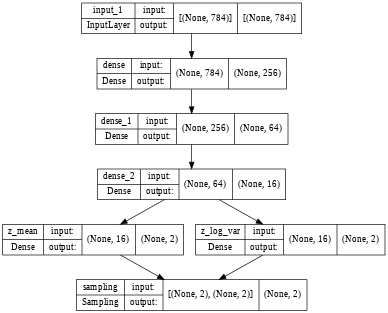

In [11]:
# Plot model
keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True,
                       rankdir='TB', expand_nested=True, dpi=48)

## Build the decoder

In [12]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim))
x = layers.Dense( 16, activation="relu")(latent_inputs)
x = layers.Dense( 64, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(784, activation="sigmoid")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 16)                48        
                                                                 
 dense_4 (Dense)             (None, 64)                1088      
                                                                 
 dense_5 (Dense)             (None, 256)               16640     
                                                                 
 dense_6 (Dense)             (None, 784)               201488    
                                                                 
Total params: 219,264
Trainable params: 219,264
Non-trainable params: 0
_________________________________________________________________


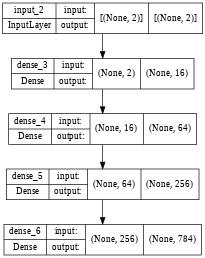

In [13]:
# Plot model
keras.utils.plot_model(decoder, show_shapes=True, show_layer_names=True,
                       rankdir='TB', expand_nested=True, dpi=48)

## Train VAE

In [14]:
# Load data in vector form
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((len(x_train), -1)).astype("float32") / 255

print(x_train.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [15]:
# Create and train model
vae = VAE(encoder, decoder, gamma=1.0)
vae.compile(optimizer='adam')
vae.fit(x=x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 4s 6ms/step - loss: 42.1829 - reconstruction_loss: 33.9276 - kl_loss: 1.0352
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 31.0076 - reconstruction_loss: 28.7443 - kl_loss: 1.9828
Epoch 3/30
469/469 [==============================] - 3s 6ms/step - loss: 30.1331 - reconstruction_loss: 27.6035 - kl_loss: 2.3902
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 29.7169 - reconstruction_loss: 26.9929 - kl_loss: 2.6220
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 29.3846 - reconstruction_loss: 26.4474 - kl_loss: 2.8354
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 29.1311 - reconstruction_loss: 26.0258 - kl_loss: 3.0148
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 28.9036 - reconstruction_loss: 25.7291 - kl_loss: 3.1281
Epoch 8/30
469/469 [==============================] - 3s 6ms/step - loss: 28.7461 -

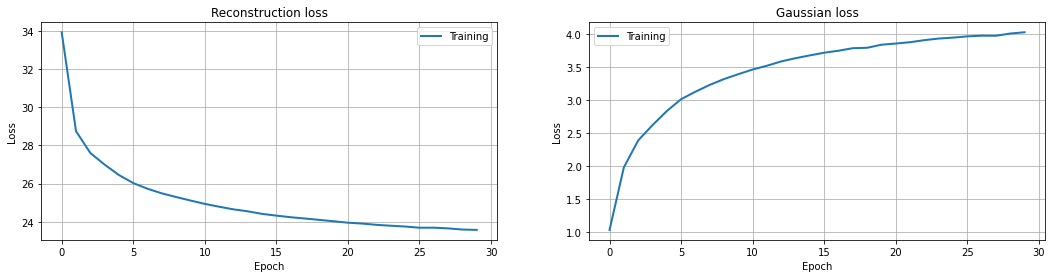

In [16]:
# Plot loss
plot_losses(vae)

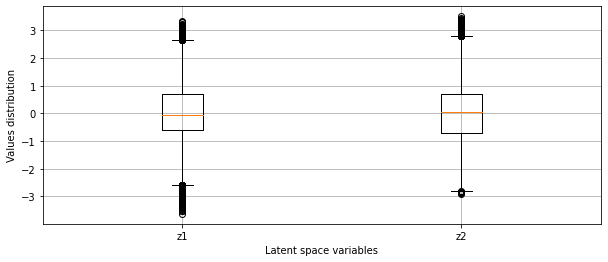

In [17]:
# Display distribution of latent space
plot_z_distribution(vae, x_train)

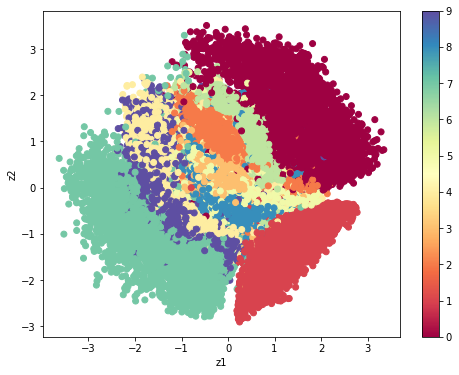

In [18]:
# Display how the latent space projects into 2D
plot_label_clusters(vae, x_train, y_train)

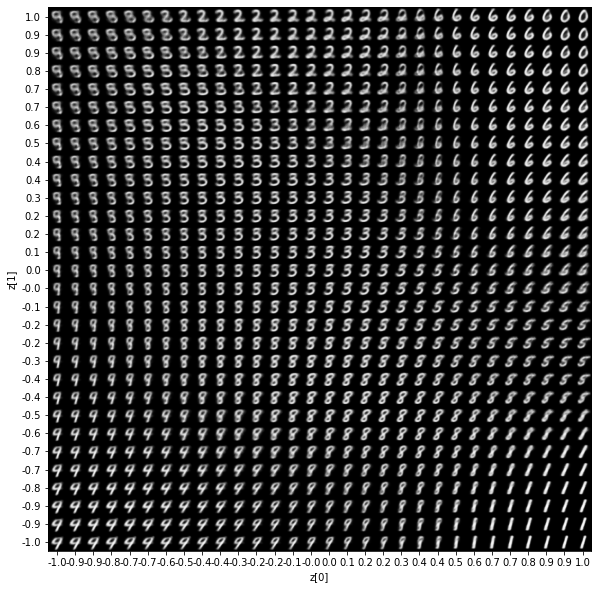

In [19]:
# Display a grid of sampled digits
plot_latent_space(vae)

# **Part 2: Convolutional Variational Autoencoder**

## Build the encoder

In [20]:
# Encoder
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Build the decoder

In [21]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_8 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Train Conv VAE

In [22]:
# Load data as matrix (image) form
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

print(x_train.shape)
print(y_train.shape)

(60000, 28, 28, 1)
(60000,)


In [23]:
# Create and train model
cvae = VAE(encoder, decoder, gamma=1.0)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 11s 19ms/step - loss: 33312.3131 - reconstruction_loss: 27004.4316 - kl_loss: 20.2671
Epoch 2/30
469/469 [==============================] - 9s 19ms/step - loss: 23519.3063 - reconstruction_loss: 22807.9023 - kl_loss: 53.6742
Epoch 3/30
469/469 [==============================] - 9s 19ms/step - loss: 20950.6677 - reconstruction_loss: 20585.1641 - kl_loss: 57.8162
Epoch 4/30
469/469 [==============================] - 10s 21ms/step - loss: 19985.2152 - reconstruction_loss: 19792.1016 - kl_loss: 49.0716
Epoch 5/30
469/469 [==============================] - 9s 20ms/step - loss: 19471.7129 - reconstruction_loss: 19373.7676 - kl_loss: 44.3728
Epoch 6/30
469/469 [==============================] - 10s 20ms/step - loss: 19174.1878 - reconstruction_loss: 19106.2988 - kl_loss: 40.7669
Epoch 7/30
469/469 [==============================] - 10s 20ms/step - loss: 18963.5482 - reconstruction_loss: 18891.2109 - kl_loss: 38.0133
Epoch 8/30
469/469 [===

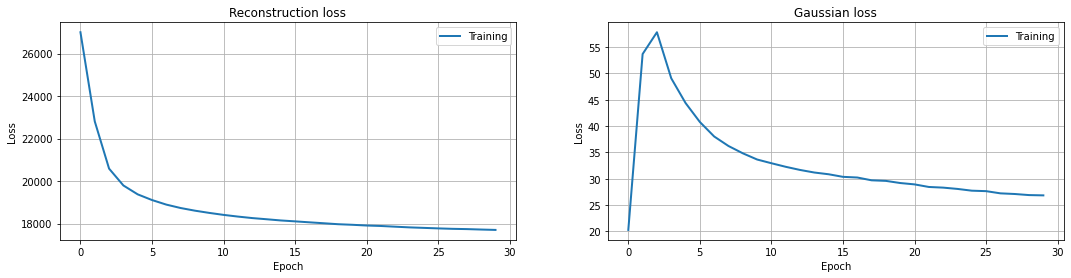

In [24]:
# Plot loss
plot_losses(cvae)

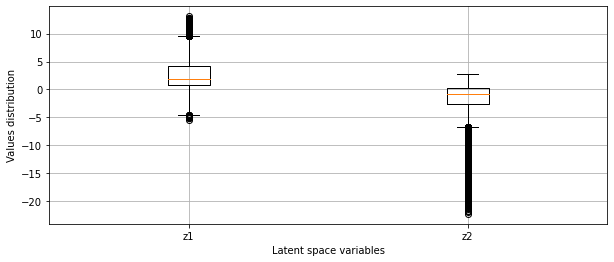

In [25]:
# Display distribution of latent space
plot_z_distribution(cvae, x_train)

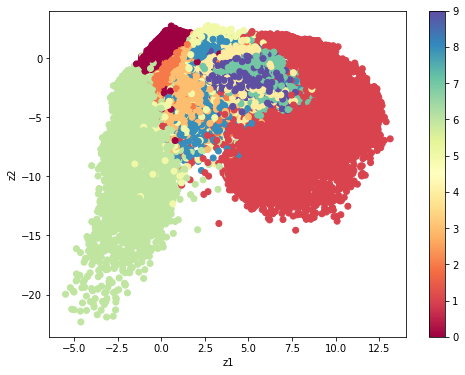

In [26]:
# Display how the latent space projects into 2D
plot_label_clusters(cvae, x_train, y_train)

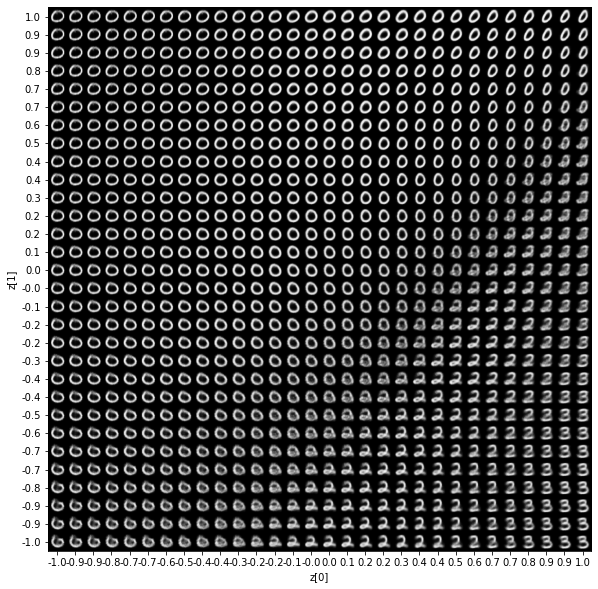

In [27]:
# Display a grid of sampled digits
plot_latent_space(cvae)

# Preguntas

In [ ]:
# == Q1 ==
# Prueba distintos tamaños de espacio latente para el autoencoder que detecta anomalías.
# ¿Existe alguna relación entre el número elementos en el espacio latente y la
# separación resultante entre los espacios latentes de los datos normales y anormales?

# == Q2 ==
# Para el AE convolucional, intenta forzar su espacio latente para que sea ralo.
# ¿Cómo lo lograrías?

# == Q3 ==
# Observa los boxplot's del espacio latente producido por el autoencoder variacional (VAE).
# Observa también los resultados visuales obtenidos al muestrear ese espacio latente
# (verás que no son muy buenos). Usando el mismo espacio latente,
# ¿cómo modificarías el muestreo para que las reconstrucciones sea más adecuadas visualmente?

# == Q4 ==
# Observa la proyección en 2D generada por el autoencoder variacional convolucional
# (VConvAE). No se ve muy Gaussiana.
# ¿Cómo modificarías el modelo para que ese espacio sea más Gaussiano?